## notes

making database of hashes
    * load audio file
    * generate spectrogram of data (will return frequencies, times, and amplitudes)
    * perform maximum filtering on data to help identify peaks in every region (should be evenly spaced in time and frequency)
    * get rid of all values that have changed when maximum filtering was performed (this is to keep only the peaks, makes the matrix much more sparse)
    * iterate through list of each peak coordinate, identify other peaks within nearby regions
    * create hashes that correspond to differences in peak timings and their corresponding frequencies
    * store hashes + time + track ID in big table

NOTES:
what do i need to finish?
    * create hashes and store in table
    * make into fingerprint function
    * try to get it to work first with multiple files
    * figure out how to identify songs
    * make that into a function
    * functionalize everything else that i can
    * optimize certain things with the sampling rate/frequency distributions, etc.
    * time everything to see how long this would take per song

notes on problems i've run into 
    * stereo vs. mono signals
    * converting from mp3 into wav (or just using mp3 directly)
    * need to take log of signal amplitude
    * strange results in spectrogram plotting when removing dc_offset --> disappears once maximum filtering applied
    * kdtree for generating distance map (for robust constellations)
    * fastest way to append a bunch of arrays together (or dataframes)
    * floating point precision problems when subtracting time values

# Code

## Imports

In [1]:
#|default_exp shablam

In [2]:
# |export
import os
from pathlib import Path
import time
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
# from pydub import AudioSegment
from scipy.io import wavfile
from tempfile import mktemp
import scipy.spatial as spatial


## Functionalize Fingerprinting

In [191]:
# |export
# read music file after identifying file type 
# only works with .wav for now though lol
def read_audio_file(filepath):
    file_type = Path(filepath).suffix

    if file_type == '.wav':
        sampling_rate, data = wavfile.read(filepath)  # read wav file
        data = np.mean(data, axis=1) # average the two stereo channels
    else:
        raise Exception('sorry, other file types not supported yet lol')
        
    return sampling_rate, data

# fn to remove dc offset from signal
def remove_dc(arr): return arr - np.mean(arr)

# maximum filtering to identify peaks
# input: times, frequencies, amplitudes of signal from spectrogram
# output: list of points that correspond to unchanged peaks
def apply_max_filter(ts, freqs, amps):
    # time_interval and freq_interval calculated so that we can get even spacing throughout frequencies and time
    time_interval = len(ts) / np.max(ts)
    freq_interval = len(freqs) / 10

    # performing maximum filtering
    max_filter = scipy.ndimage.maximum_filter(amps, size=(freq_interval, time_interval))

    # identify which values are unchanged after doing filtering
    unchanged = max_filter == amps # unchanged = boolean matrix
    
    # get the coordinates of unchanged peaks
    # NOTE: THESE ARE THE INDICES, NOT THE VALUES THEMSELVES
    peak_freqs, peak_ts = np.where(unchanged)

    # make two column array to hold peak frequencies and times
    peak_ts_freqs = np.zeros((len(peak_freqs),2))
    
    # replace indices with corresponding times and frequencies
    peak_ts_freqs[:,0] = ts[peak_ts.astype(int)]
    peak_ts_freqs[:,1] = freqs[peak_freqs.astype(int)]
    
    # sort by time column (just seems like it'll make things easier?)
    peak_ts_freqs = peak_ts_freqs[peak_ts_freqs[:,0].argsort()]

    return peak_ts_freqs

# get track id from filepath
def get_track_id(filepath): return Path(filepath).stem

# identify all point relationships for robust constellation
def find_point_relationships(list_of_points, relationship_tree, distance):
    # initialize list to hold all relationship arrays so we can process everything at once
    temp_list = []
    
    # iterate through each point, get all points within some distance (will need to play around with distance value), filter only
    # points that are later in time, create hash, add to pandas dataframe pairwise
    num_points = len(list_of_points)
    for i in range(num_points):
        # get current point
        cur = list_of_points[i]
        
        # get all values within distance 500 of point 
        nearby = list_of_points[relationship_tree.query_ball_point(cur, distance)]
        
        # filter only points that are later in time
        after = nearby[nearby[:,0] > cur[0]]
        point_arr = np.zeros((len(after),8)) # one column for each df column, one row for each point
        
        point_arr[:,0] = cur[1] # point 1 frequencies
        point_arr[:,1] = after[:,1] # frequencies of all point 2s
        
        point_arr[:,2] = cur[0] # point 1 times
        point_arr[:,3] = after[:,0] # times of all point 2s
        
        temp_list.append(point_arr) # appending to the list is most efficient, process all at the end
    
    # concatenate all arrays in the list along the rows (axis=0)
    point_relationships = np.vstack(temp_list)
    
    return point_relationships

# fn to create song_df from array of point relationships
def create_song_df(point_relationships):
    # column names for dataframe
    columns=['f1', 'f2', 't1', 't2', 't_delta', 'hash_tuple', 'hash', 'track_id']

    # create df with all point relationships
    song_df = pd.DataFrame(data=point_relationships, columns=columns)
    
    # round each column to corresponding decimal places
    song_df = song_df.round({'f1': 3, 'f2': 3, 't1': 3, 't2': 3})

    # calculate hashes from time difference and frequencies
    song_df['t_delta'] = song_df['t2'] - song_df['t1']
    song_df['hash_tuple'] = list(zip(np.round(song_df['f1'], decimals=3), 
                                     np.round(song_df['f2'], decimals=3), 
                                     np.round(song_df['t_delta'], decimals=3)
                                    )
                                )
    song_df['hash'] = song_df['hash_tuple'].apply(hash)
    
    return song_df 
    
# fingerprint song and add to csv file
def generate_fingerprint(wav_filepath):
    # get track id for song identification
    track_id = get_track_id(wav_filepath)

    # read music file data
    sample_rate, samples = read_audio_file(wav_filepath)
    samples = remove_dc(samples) # remove DC offset

    # generate spectrogram, get frequencies, times, amplitudes
    freqs, ts, amps = scipy.signal.spectrogram(samples, sample_rate)

    # apply max filter and get list of points that correspond to unchanged peaks
    peak_ts_freqs = apply_max_filter(ts, freqs, amps)
    
    # create KDTree of all points so that we can identify neighborhoods (will be needed for 
    # robust constellations)
    kd_tree = spatial.KDTree(peak_ts_freqs)

    # find all point relationships within specified distance
    point_relationships = find_point_relationships(peak_ts_freqs, kd_tree, 200)

    # create song_df with above relationships
    song_df = create_song_df(point_relationships)

    # set track_id
    song_df['track_id'] = track_id

    # keep only the columns that we need for the csv db file
    columns_to_export = song_df[['t1', 'hash', 'track_id']].copy()

    return columns_to_export

# append to the master song hash db file
def add_song_to_db(song_filepath, db_filepath=db_filepath):
    song_fingerprint = generate_fingerprint(song_filepath) # generate fingerprint for new song
    db = pd.read_csv(db_filepath, index_col=0) # load db from file
    db = pd.concat([db, song_fingerprint], ignore_index=True) # add song df to db file
    db.to_csv(db_filepath) # save db again to same file
    return db

In [184]:
file1 = '/Users/sunday/Downloads/DJ_Got_Us_Fallin_In_Love_Usher.wav'
file2 = '/Users/sunday/Downloads/Visual_Conspire_Stereo.wav'

In [185]:
song_fingerprint_1 = generate_fingerprint(file1)
song_fingerprint_1.to_csv('shablam_db.csv')

In [188]:
begin = time.time()
appended = add_song_to_db(file2)
end = time.time()

## Identify Song

what do i need to do for this?
    * load audio file in same way as before
    * create all the same types of hashes as before
    * load file with all song hashes
    * identify matching hashes 


In [192]:
# |export
def identify_song(snippet_filepath, db_filepath=db_filepath):
    # load up the db brother
    db = pd.read_csv(db_filepath, index_col=0)
    
    # generate fingerprint in the same way as before
    snippet_df = generate_fingerprint(snippet_filepath)

    # identify rows in db_file that correspond to hashes in snippet_df
    filtered_db = db[db['hash'].isin(snippet_df['hash'])]

    # Merge the dataframes using the 'hash' column
    merged_df = pd.merge(filtered_db, snippet_df, on='hash', suffixes=('_db', '_snippet'))

    # calculate time offset of our snippet from the original file
    merged_df['offset'] = merged_df['t1_db'] - merged_df['t1_snippet']

    # find most common time offset for matching hashes
    most_common_offset = merged_df[merged_df['offset'] == merged_df['offset'].mode()[0]]

    # identify most common track id from these common time offsets
    most_likely_song = most_common_offset['track_id_db'].mode()[0]

    return most_likely_song

In [193]:
db_filepath = '/Users/sunday/Desktop/projects/shazam/shablam_db.csv'
snippet_filepath_1 = '/Users/sunday/Downloads/usher_snippet.wav'
snippet_filepath_2 = '/Users/sunday/Downloads/Visual_Conspire_Stereo_snippet.wav'

In [195]:
identify_song(snippet_filepath_2)

/var/folders/1w/qvf0dg610jb7nwsydxyhfc900000gp/T/ipykernel_14407/938700701.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_rate, data = wavfile.read(filepath)  # read wav file


'Visual_Conspire_Stereo'

## fingerprinting development

In [104]:
filepath = '/Users/sunday/Downloads/usher.wav'
track_id = hash('Visual_Conspire')

In [113]:
# read .wav file data and get sample rate
sample_rate, samples = read_audio_file(filepath)  # read wav file
# samples = samples - np.mean(samples) # remove dc_offset

# generate spectrogram, get frequencies, times, amplitudes
freqs, ts, amps = scipy.signal.spectrogram(samples, sample_rate)


/var/folders/1w/qvf0dg610jb7nwsydxyhfc900000gp/T/ipykernel_14407/3321389828.py:1: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(ts,freqs,np.log(amps))


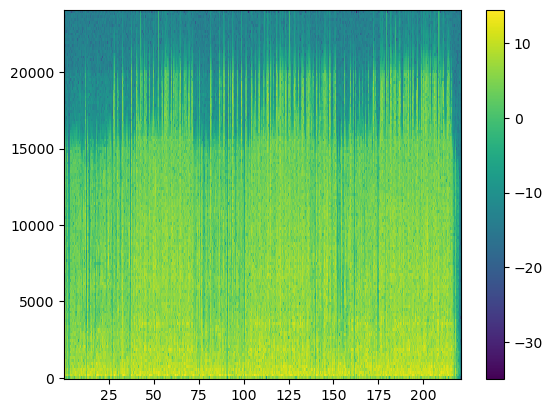

In [114]:
plt.pcolormesh(ts,freqs,np.log(amps))
plt.colorbar()

In [107]:
# maximum filtering
# time_interval and freq_interval calculated so that we can get even spacing throughout frequencies and time
time_interval = len(ts) / np.max(ts)
freq_interval = len(freqs) / 10

# performing maximum filtering
max_filter = scipy.ndimage.maximum_filter(amps, size=(freq_interval, time_interval))

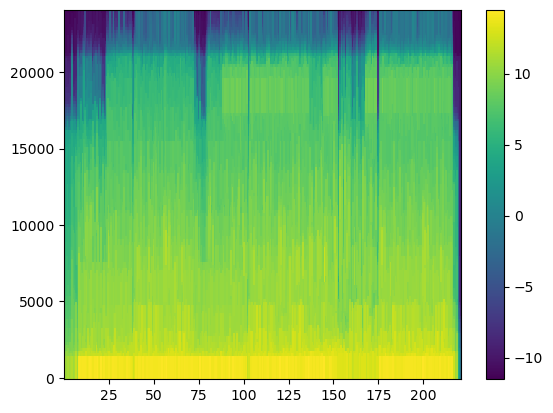

In [108]:
# plot smoothened/max filtered spectrogram
plt.pcolormesh(ts,freqs,np.log(max_filter))
plt.colorbar()

In [115]:
# identify which values are unchanged after doing filtering
unchanged = max_filter == amps # unchanged = boolean matrix

# get the coordinates of peaks that are remaining
# NOTE: THESE ARE THE INDICES, NOT THE VALUES THEMSELVES
peak_freqs, peak_ts = np.where(unchanged)

coords = zip(peak_ts, peak_freqs)

In [116]:
# make two column array to hold peak frequencies and times
peak_ts_freqs = np.zeros((len(peak_freqs),2))

# replace indices with corresponding times and frequencies
peak_ts_freqs[:,0] = ts[peak_ts.astype(int)]
peak_ts_freqs[:,1] = freqs[peak_freqs.astype(int)]

# sort by time column (just seems like it'll make things easier?)
peak_ts_freqs = peak_ts_freqs[peak_ts_freqs[:,0].argsort()]

In [117]:
# create KDTree of all points so that we can identify neighborhoods (will be needed for 
# robust constellations)
kd_tree = spatial.KDTree(peak_ts_freqs)

In [99]:
columns=['f1', 'f2', 't1', 't2', 't_delta', 'hash_tuple', 'hash', 'track_id']
num_columns = len(columns)

# initialize list to hold all relationship arrays so we can process everything at once
temp_list = []

# iterate through each point, get all points within some distance (will need to play around with it), filter only
# points that are later in time, create hash, add to pandas dataframe pairwise
num_points = len(peak_ts_freqs)

for i in range(num_points):
    # get current point
    cur = peak_ts_freqs[i]
    
    # get all values within distance 500 of point 
    nearby = peak_ts_freqs[kd_tree.query_ball_point(cur, 200)]
    
    # filter only points that are later in time
    after = nearby[nearby[:,0] > cur[0]]
    point_arr = np.zeros((len(after),num_columns)) # one column for each df column, one row for each point
    
    point_arr[:,0] = cur[1] # point 1 frequencies
    point_arr[:,1] = after[:,1] # frequencies of all point 2s
    
    point_arr[:,2] = cur[0] # point 1 times
    point_arr[:,3] = after[:,0] # times of all point 2s
    
    temp_list.append(point_arr) # appending to the list is most efficient, process all at the end

# concatenate all arrays in the list along the rows (axis=0)
point_relationships = np.vstack(temp_list)

# create df with all point relationships
song_df = pd.DataFrame(data=point_relationships, columns=columns)

# round each column to corresponding decimal places
song_df = song_df.round({'f1': 2, 'f2': 2, 't1': 3, 't2': 3})

In [66]:
song_df['t_delta'] = song_df['t2'] - song_df['t1']
song_df['hash_tuple'] = list(zip(np.round(song_df['f1'], decimals=2), 
                                 np.round(song_df['f2'], decimals=2), 
                                 np.round(song_df['t_delta'], decimals=3)
                                )
                            )
song_df['hash'] = song_df['hash_tuple'].apply(hash)
song_df['track_id'] = track_id

In [52]:
columns_to_export = song_df[['t1', 'hash', 'track_id']].copy()

In [79]:
columns_to_export

,t1,hash,track_id
0,0.638,-5428062727887350148,2160483888033806250
1,0.638,1333534921586973052,2160483888033806250
2,0.638,704117078247691982,2160483888033806250
3,0.638,-2497837088606230207,2160483888033806250
4,0.638,6872891145871429883,2160483888033806250
...,...,...,...
7750,71.972,-5165290606339709743,2160483888033806250
7751,71.972,3907728451090446970,2160483888033806250
7752,72.237,-6237587960980180836,2160483888033806250
7753,73.024,7448079146900756028,2160483888033806250


In [54]:
columns_to_export.to_csv('shablam_db.csv')

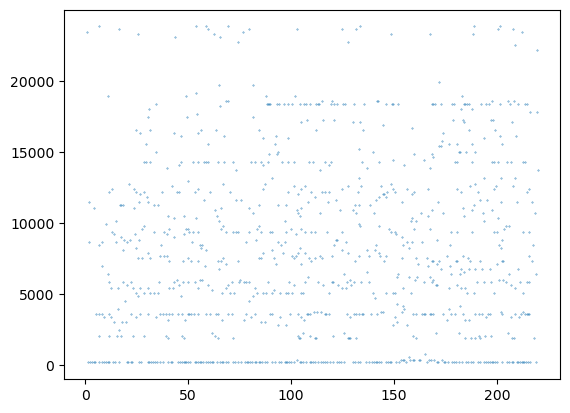

In [118]:
plt.scatter(peak_ts_freqs[:,0], peak_ts_freqs[:,1], s=0.1)

In [ ]:
# saved/backup in case I want it later
peaks_n_freqs = freqs.reshape(-1,1) * unchanged # matrix with the corresponding frequency replacing the boolean from unchanged, will make hashes easier later

## Export to python file

In [168]:
import nbdev

In [196]:
nbdev.export.nb_export('shablam.ipynb', '.')